In [2]:
#!/usr/bin/env python3
# Two-way ANOVA analysis for genomic oxidation data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import statsmodels.api as sm
import os
import re
from tqdm import tqdm
import multiprocessing as mp
from functools import partial
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

In [3]:
def preprocess_data(file_path):
    """
    Preprocess the raw data file to extract bin information and create a feature matrix
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file with oxidation data
        
    Returns:
    --------
    tuple
        (pivot_df, bin_ids, metadata_df)
        pivot_df: DataFrame with samples as rows and bins as columns
        bin_ids: List of bin IDs
        metadata_df: DataFrame with sample metadata extracted from sample names
    """
    print(f"Reading data from {file_path}...")
    
    # Extract bin size from file path
    bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    print(f"Detected bin size: {bin_size}")
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Create FeatureID by combining Bin, Strand, and Chromosome
    df['FeatureID'] = df['Bin'].astype(str) + '_' + df['Strand'] + df['Chromosome'].astype(str)
    
    # Handle potential duplicates by grouping
    df['Group'] = df.groupby(['Sample', 'FeatureID']).cumcount().astype(str)
    
    # Show sample of the processed data
    print("Sample of the processed dataframe:")
    print(df[['Sample', 'Bin', 'Strand', 'FeatureID', 'Group', 'Median_Normalized_Damage']].head(5))
    
    # Create pivot table: samples as rows, features as columns
    pivot_df = df.pivot_table(
        index='Sample', 
        columns='FeatureID', 
        values='Median_Normalized_Damage',
        aggfunc='mean'
    )
    
    # Extract bin IDs (these will be the column names in the pivot table)
    bin_ids = pivot_df.columns.tolist()
    
    # Extract metadata from sample names
    metadata_df = pd.DataFrame(index=pivot_df.index)
    
    # Extract group (treatment) and time point from sample names
    metadata_df['treatment'] = metadata_df.index.map(lambda x: re.search(r'(CRS|Ctrl)', x).group(1) if re.search(r'(CRS|Ctrl)', x) else "Unknown")
    metadata_df['timepoint'] = metadata_df.index.map(lambda x: re.search(r'(evening|morning)', x).group(1) if re.search(r'(evening|morning)', x) else "Unknown")
    
    # Reset index to make Sample a standard column
    metadata_df = metadata_df.reset_index().rename(columns={'index': 'Sample'})
    
    print(f"Created pivot table with {pivot_df.shape[0]} samples and {pivot_df.shape[1]} genomic features")
    print(f"Extracted metadata with factors: treatment ({metadata_df['treatment'].unique()}) and timepoint ({metadata_df['timepoint'].unique()})")
    print(metadata_df.head(5))
    
    return pivot_df, bin_ids, metadata_df

In [4]:
def perform_two_way_anova(bin_data, factor1_name, factor2_name):
    try:
        # Create the formula for the model
        formula = f"measurement ~ C({factor1_name}) + C({factor2_name}) + C({factor1_name}):C({factor2_name})"
        
        # Fit the model (using Type III SS)
        model = ols(formula, data=bin_data).fit()
        
        # Get ANOVA table
        anova_table = sm.stats.anova_lm(model, typ=3)
        
        # Extract results
        results = {
            'factor1_pvalue': anova_table.loc[f'C({factor1_name})', 'PR(>F)'],
            'factor2_pvalue': anova_table.loc[f'C({factor2_name})', 'PR(>F)'],
            'interaction_pvalue': anova_table.loc[f'C({factor1_name}):C({factor2_name})', 'PR(>F)'],
            'factor1_Fvalue': anova_table.loc[f'C({factor1_name})', 'F'],
            'factor2_Fvalue': anova_table.loc[f'C({factor2_name})', 'F'],
            'interaction_Fvalue': anova_table.loc[f'C({factor1_name}):C({factor2_name})', 'F']
        }
        
        return results
    
    except Exception as e:
        # Return NaN values if error occurs
        return {
            'factor1_pvalue': np.nan,
            'factor2_pvalue': np.nan,
            'interaction_pvalue': np.nan,
            'factor1_Fvalue': np.nan,
            'factor2_Fvalue': np.nan,
            'interaction_Fvalue': np.nan
        }

In [5]:
def process_bin(args):
    """Process a single bin - for parallel processing"""
    bin_idx, bin_id, pivot_df, metadata_df, factor1_name, factor2_name = args
    
    # Extract measurements for this bin
    bin_values = pivot_df.iloc[:, bin_idx].values
    
    # Create DataFrame with measurements and factors
    df = pd.DataFrame({
        'measurement': bin_values,
        'Sample': pivot_df.index.tolist()
    })

    
    # Merge with metadata to get the factors
    df = pd.merge(df, metadata_df, on='Sample')
    
    # Perform ANOVA
    result = perform_two_way_anova(df, factor1_name, factor2_name)
    result['bin_id'] = bin_id
    
    return result

In [6]:
def create_batches(items, batch_size):
    """Split a list of items into batches of specified size"""
    for i in range(0, len(items), batch_size):
        yield items[i:i + batch_size]


def process_batch(batch_args):
    """Process a batch of bins"""
    batch_bins_with_idx, pivot_data, meta_data, f1_name, f2_name = batch_args
    batch_results = []
    
    for bin_idx, bin_id in batch_bins_with_idx:
        # Call the original process_bin function with the correct bin_idx
        result = process_bin((bin_idx, bin_id, pivot_data, meta_data, f1_name, f2_name))
        batch_results.append(result)
        
    return batch_results


def process_batch_concurrent(batch_bins_with_idx):
    """Process a batch of bins for concurrent.futures implementation"""
    # This function can access pivot_df, metadata_df, etc. via global variables
    # which will be properly initialized in the child processes
    batch_results = []
    for bin_idx, bin_id in batch_bins_with_idx:
        result = process_bin((bin_idx, bin_id, pivot_df, metadata_df, factor1_name, factor2_name))
        batch_results.append(result)
    return batch_results

In [7]:
def analyze_genomic_bins(file_path, factor1_name='treatment', factor2_name='timepoint', 
                       output_prefix=None, figures_dir=None, data_dir=None,
                       n_cores=64, batch_size=1000):
    """
    Analyze thousands of genomic bins with two-way ANOVA
    
    Parameters:
    -----------
    file_path : str
        Path to CSV file with oxidation data
    factor1_name : str
        Name of the first factor (default: 'treatment')
    factor2_name : str
        Name of the second factor (default: 'timepoint')
    output_prefix : str
        Prefix for output files (default: derived from input file)
    figures_dir : str
        Directory to save all PNG figures (default: None, uses current directory)
    data_dir : str
        Directory to save all CSV data files (default: None, uses current directory)
    n_cores : int, optional
        Number of CPU cores to use for parallel processing
    batch_size : int, optional
        Number of bins to process in each batch (default: 100)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with ANOVA results for all bins
    """
    # Set default output prefix if not provided
    if output_prefix is None:
        bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
        output_prefix = "anova_" + bin_size

    # Create output directories if specified
    if figures_dir is not None:
        os.makedirs(figures_dir, exist_ok=True)
    
    if data_dir is not None:
        os.makedirs(data_dir, exist_ok=True)
    
    # Process the data
    pivot_df, bin_ids, metadata_df = preprocess_data(file_path)
    
    # Determine number of cores for parallel processing
    if n_cores is None:
        n_cores = max(1, mp.cpu_count() - 1)  # Leave one core free
    
    total_bins = len(bin_ids)
    print(f"Processing {total_bins} bins using {n_cores} cores with batch size {batch_size}...")
    
    # Create a list of (bin_idx, bin_id) pairs
    bin_idx_id_pairs = list(enumerate(bin_ids))
    
    # Group these pairs into batches
    bin_batches_with_idx = list(create_batches(bin_idx_id_pairs, batch_size))
    
    # Prepare batch arguments
    batch_args_list = [(batch, pivot_df, metadata_df, factor1_name, factor2_name) 
                      for batch in bin_batches_with_idx]
    
    # Results container
    all_results = []
    
    # Set up parallel processing with chunked work
    with mp.Pool(n_cores) as pool:
        # Use imap to maintain order of batches
        batch_iterator = pool.imap(process_batch, batch_args_list)
        
        # Process batches with progress bar
        with tqdm(total=total_bins) as pbar:
            for batch_results in batch_iterator:
                all_results.extend(batch_results)
                pbar.update(len(batch_results))
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # No need to sort since we maintained the original order with imap
    
    # Apply multiple testing correction
    for col in ['factor1_pvalue', 'factor2_pvalue', 'interaction_pvalue']:
        # Benjamini-Hochberg FDR correction
        mask = ~np.isnan(results_df[col])
        corrected = np.full(len(results_df), np.nan)
        
        if mask.sum() > 0:
            corrected[mask] = multipletests(results_df.loc[mask, col], method='fdr_bh')[1]
            
        results_df[f'{col}_adj'] = corrected
        
        # Add significance flag (True/False)
        results_df[f'{col.replace("pvalue", "significant")}'] = results_df[f'{col}_adj'] < 0.05
    
    # Prepare output path
    if data_dir is not None:
        results_path = os.path.join(data_dir, f"{output_prefix}_results.csv")
    else:
        results_path = f"{output_prefix}_results.csv"
    
    # Write results to file
    results_df.to_csv(results_path, index=False)
    
    print(f"Analysis complete. Found:")
    print(f"  - {results_df['factor1_significant'].sum()} bins significant for {factor1_name}")
    print(f"  - {results_df['factor2_significant'].sum()} bins significant for {factor2_name}")
    print(f"  - {results_df['interaction_significant'].sum()} bins significant for interaction")
    print(f"  - Results CSV saved to: {results_path}")
    
    return results_df

In [8]:
# For the concurrent.futures version, we need to handle globals differently
# These will be initialized in the child processes
pivot_df = None
metadata_df = None
factor1_name = None
factor2_name = None

def initialize_worker(pivot_data, meta_data, f1_name, f2_name):
    """Initialize global variables in worker processes"""
    global pivot_df, metadata_df, factor1_name, factor2_name
    pivot_df = pivot_data
    metadata_df = meta_data
    factor1_name = f1_name
    factor2_name = f2_name


In [9]:
def analyze_genomic_bins_concurrent(file_path, factor1_name='treatment', factor2_name='timepoint', 
                          output_prefix=None, figures_dir=None, data_dir=None,
                          n_cores=64, batch_size=10000):
    """
    Analyze thousands of genomic bins with two-way ANOVA using concurrent.futures
    
    Parameters:
    -----------
    file_path : str
        Path to CSV file with oxidation data
    factor1_name : str
        Name of the first factor (default: 'treatment')
    factor2_name : str
        Name of the second factor (default: 'timepoint')
    output_prefix : str
        Prefix for output files (default: derived from input file)
    figures_dir : str
        Directory to save all PNG figures (default: None, uses current directory)
    data_dir : str
        Directory to save all CSV data files (default: None, uses current directory)
    n_cores : int, optional
        Number of CPU cores to use for parallel processing
    batch_size : int, optional
        Number of bins to process in each batch (default: 100)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with ANOVA results for all bins
    """
    # Set default output prefix if not provided
    if output_prefix is None:
        bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
        output_prefix = "anova_" + bin_size 
    
    # Create output directories if specified
    if figures_dir is not None:
        os.makedirs(figures_dir, exist_ok=True)
    
    if data_dir is not None:
        os.makedirs(data_dir, exist_ok=True)
    
    # Process the data
    pivot_df, bin_ids, metadata_df = preprocess_data(file_path)
    
    # Determine number of cores for parallel processing
    if n_cores is None:
        n_cores = max(1, mp.cpu_count() - 1)  # Leave one core free
    
    total_bins = len(bin_ids)
    print(f"Processing {total_bins} bins using {n_cores} cores with batch size {batch_size}...")
    
    # Create batches of bin_ids to reduce overhead
    bin_idx_id_pairs = list(enumerate(bin_ids))
    bin_batches_with_idx = list(create_batches(bin_idx_id_pairs, batch_size))
    
    # Results container
    all_results = []
    
    # Set up progress bar
    pbar = tqdm(total=total_bins)
    
    # Use ProcessPoolExecutor with initialization
    ctx = mp.get_context('spawn')  # Use 'spawn' for better compatibility
    with concurrent.futures.ProcessPoolExecutor(
        max_workers=n_cores,
        mp_context=ctx,
        initializer=initialize_worker,
        initargs=(pivot_df, metadata_df, factor1_name, factor2_name)
    ) as executor:
        # Map maintains order of results
        for batch_results in executor.map(process_batch_concurrent, bin_batches_with_idx):
            all_results.extend(batch_results)
            pbar.update(len(batch_results))
    
    pbar.close()
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # No need to sort since we maintained the original order with map
    
    # Apply multiple testing correction
    for col in ['factor1_pvalue', 'factor2_pvalue', 'interaction_pvalue']:
        # Benjamini-Hochberg FDR correction
        mask = ~np.isnan(results_df[col])
        corrected = np.full(len(results_df), np.nan)
        
        if mask.sum() > 0:
            corrected[mask] = multipletests(results_df.loc[mask, col], method='fdr_bh')[1]
            
        results_df[f'{col}_adj'] = corrected
        
        # Add significance flag (True/False)
        results_df[f'{col.replace("pvalue", "significant")}'] = results_df[f'{col}_adj'] < 0.05
    
    # Prepare output path
    if data_dir is not None:
        results_path = os.path.join(data_dir, f"{output_prefix}_results.csv")
    else:
        results_path = f"{output_prefix}_results.csv"
    
    # Write results to file
    results_df.to_csv(results_path, index=False)
    
    print(f"Analysis complete. Found:")
    print(f"  - {results_df['factor1_significant'].sum()} bins significant for {factor1_name}")
    print(f"  - {results_df['factor2_significant'].sum()} bins significant for {factor2_name}")
    print(f"  - {results_df['interaction_significant'].sum()} bins significant for interaction")
    print(f"  - Results CSV saved to: {results_path}")
    
    return results_df

In [10]:
def visualize_anova_results(results_df, factor1_name, factor2_name, output_prefix, plots_dir, data_dir):
    """
    Create visualizations of ANOVA results
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        DataFrame with ANOVA results from analyze_genomic_bins()
    factor1_name : str
        Name of the first factor
    factor2_name : str
        Name of the second factor
    output_prefix : str
        Prefix for output files
        
    Returns:
    --------
    dict
        Dictionary with matplotlib figure objects
    """
    if output_prefix is None:
        bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
        output_prefix = "anova_" + bin_size 
        
    print("Creating visualizations...")
    figures = {}
    
    # 1. Manhattan-like plot of p-values
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(results_df)), -np.log10(results_df['factor1_pvalue']), 
               alpha=0.5, s=10, label=factor1_name)
    plt.scatter(range(len(results_df)), -np.log10(results_df['factor2_pvalue']), 
               alpha=0.5, s=10, label=factor2_name)
    plt.scatter(range(len(results_df)), -np.log10(results_df['interaction_pvalue']), 
               alpha=0.5, s=10, label='Interaction')
    
    # Add significance thresholds
    plt.axhline(-np.log10(0.05), linestyle='--', color='red', label='p=0.05')
    plt.axhline(-np.log10(0.05/len(results_df)), linestyle='--', color='blue', label='Bonferroni')
    
    plt.xlabel('Genomic Bin Index')
    plt.ylabel('-log10(p-value)')
    plt.title('Manhattan Plot of Two-way ANOVA p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/manhattan_plot.png", dpi=300)
    figures['manhattan'] = plt.gcf()
    
    # 2. Volcano plots for each factor
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_Fvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_Fvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_Fvalue', 'interaction_significant')
    ]
    
    for name, pval_col, fval_col, sig_col in factor_cols:
        plt.figure(figsize=(8, 6))
        
        # Create a mask for non-NaN values
        mask = ~np.isnan(results_df[pval_col]) & ~np.isnan(results_df[fval_col])
        
        # Create a scatter plot with color indicating significance
        plt.scatter(
            results_df.loc[mask, fval_col],
            -np.log10(results_df.loc[mask, pval_col]),
            c=results_df.loc[mask, sig_col].map({True: 'red', False: 'black'}),
            alpha=0.5,
            s=15
        )
        
        plt.axhline(-np.log10(0.05), linestyle='--', color='red', label='p=0.05')
        plt.xlabel('F value (effect size)')
        plt.ylabel('-log10(p-value)')
        plt.title(f'Volcano Plot: {name}')
        plt.tight_layout()
        
        plt.savefig(f"{plots_dir}/volcano_{name.lower().replace(' ', '_')}.png", dpi=300)
        figures[f'volcano_{name.lower().replace(" ", "_")}'] = plt.gcf()
    
    # 3. Distribution of p-values
    plt.figure(figsize=(10, 6))
    
    # Create histograms for each factor
    bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
    
    for i, (name, col) in enumerate(zip(
        [factor1_name, factor2_name, 'Interaction'],
        ['factor1_pvalue', 'factor2_pvalue', 'interaction_pvalue']
    )):
        # Skip NaN values
        p_values = results_df[col].dropna()
        if len(p_values) > 0:
            plt.hist(p_values, bins=bins, alpha=0.5, label=name)
    
    plt.xlabel('p-value')
    plt.ylabel('Count')
    plt.title('Distribution of p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/pvalue_distribution.png", dpi=300)

    figures['pvalue_distribution'] = plt.gcf()
    
    # 4. Pie charts for significant results
    plt.figure(figsize=(15, 5))

     # Extract counts
    sig_factor1 = results_df['factor1_significant'].sum()
    sig_factor2 = results_df['factor2_significant'].sum()
    sig_interaction = results_df['interaction_significant'].sum()
    total_bins = len(results_df)
    
    # Create subplots for pie charts
    plt.subplot(1, 3, 1)
    plt.pie([sig_factor1, total_bins - sig_factor1], 
           labels=[f'Significant\n{sig_factor1} ({sig_factor1/total_bins:.1%})', 
                  f'Not significant\n{total_bins - sig_factor1} ({1-sig_factor1/total_bins:.1%})'],
           colors=['red', 'lightgray'], autopct='%1.1f%%')
    plt.title(f'Significant bins: {factor1_name}')
    
    plt.subplot(1, 3, 2)
    plt.pie([sig_factor2, total_bins - sig_factor2],
           labels=[f'Significant\n{sig_factor2} ({sig_factor2/total_bins:.1%})', 
                  f'Not significant\n{total_bins - sig_factor2} ({1-sig_factor2/total_bins:.1%})'],
           colors=['blue', 'lightgray'], autopct='%1.1f%%')
    plt.title(f'Significant bins: {factor2_name}')
    
    plt.subplot(1, 3, 3)
    plt.pie([sig_interaction, total_bins - sig_interaction],
           labels=[f'Significant\n{sig_interaction} ({sig_interaction/total_bins:.1%})', 
                  f'Not significant\n{total_bins - sig_interaction} ({1-sig_interaction/total_bins:.1%})'],
           colors=['purple', 'lightgray'], autopct='%1.1f%%')
    plt.title(f'Significant bins: Interaction')
    
    plt.tight_layout()
    plt.savefig(f"{plots_dir}/significance_summary.png", dpi=300)

    figures['significance_summary'] = plt.gcf()
    
    # 5. Overlap between significant sets (Venn-like diagram)
    # Create a DataFrame with all combinations of significance
    sig_df = pd.DataFrame({
        factor1_name: results_df['factor1_significant'],
        factor2_name: results_df['factor2_significant'],
        'Interaction': results_df['interaction_significant']
    })
    
    # Create a summary table
    summary = pd.DataFrame(columns=['Category', 'Count'])
    
    # Add total
    summary = pd.concat([summary, pd.DataFrame({'Category': ['Total bins'], 'Count': [total_bins]})])
    
    # Add individual significances
    for factor in [factor1_name, factor2_name, 'Interaction']:
        count = sig_df[factor].sum()
        summary = pd.concat([summary, pd.DataFrame({'Category': [f'Significant for {factor}'], 'Count': [count]})])

    
    # Add overlap counts
    for i, f1 in enumerate([factor1_name, factor2_name, 'Interaction']):
        for f2 in [factor1_name, factor2_name, 'Interaction'][i+1:]:
            count = (sig_df[f1] & sig_df[f2]).sum()
            summary = pd.concat([summary, pd.DataFrame({'Category': [f'Significant for both {f1} and {f2}'], 'Count': [count]})])
    
    # Add triple overlap
    count = (sig_df[factor1_name] & sig_df[factor2_name] & sig_df['Interaction']).sum()
    summary = pd.concat([summary, pd.DataFrame({'Category': ['Significant for all three factors'], 'Count': [count]})])

    bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    # Save summary in current directory
    summary.to_csv(f"{data_dir}/{output_prefix}_{bin_size}_significance_summary.csv", index=False)
    
    print("Visualizations complete. All plots saved to", plots_dir)
    
    return figures

def plot_significant_bins(file_path, results_df, factor1_name, factor2_name, output_prefix, max_bins=10, bin_plots_dir=None):
    """
    Plot significant bins with their oxidation patterns across factors
    
    Parameters:
    -----------
    file_path : str
        Path to the original data file
    results_df : pandas.DataFrame
        ANOVA results from analyze_genomic_bins()
    factor1_name : str
        Name of the first factor
    factor2_name : str
        Name of the second factor
    output_prefix : str
        Prefix for output files
    max_bins : int
        Maximum number of top bins to plot
    """

    if output_prefix is None:
        bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
        output_prefix = "anova_" + bin_size 
    # Process the data again to get the pivot table and metadata
    pivot_df, bin_ids, metadata_df = preprocess_data(file_path)
    
    print(f"Plotting top significant bins...")
    
    # For each factor, plot the top significant bins
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_significant')
    ]
    
    # Dictionary to store DataFrames with top bins
    top_bins_dict = {}

    for name, pval_col, sig_col in factor_cols:
        # Get significant bins
        sig_bins = results_df[results_df[sig_col] == True].copy()
        
        if len(sig_bins) == 0:
            print(f"No significant bins found for {name}")
            continue
            
        # Sort by p-value
        sig_bins = sig_bins.sort_values(pval_col)
        
        # Take top bins
        top_bins = sig_bins.head(min(max_bins, len(sig_bins)))
        top_bins_dict[f"{name.lower()}_top_bins"] = top_bins
        
        # Save to file in current directory
        bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
        top_bins.to_csv(f"{data_dir}/{output_prefix}_{bin_size}_{name.lower()}_top_bins.csv", index=False)
        
        # Plot each top bin
        for i, row in enumerate(top_bins.itertuples()):
            try:
                # Get the bin ID
                bin_id = row.bin_id
                
                # Check if bin exists in pivot table
                if bin_id not in pivot_df.columns:
                    print(f"Warning: Bin {bin_id} not found in data")
                    continue
                
                # Create a DataFrame for this bin
                bin_data = pd.DataFrame({
                    'Sample': pivot_df.index,
                    'measurement': pivot_df[bin_id].values
                })
                
                # Merge with metadata
                bin_data = pd.merge(bin_data, metadata_df, on='Sample')
                
                # Create the plot
                plt.figure(figsize=(10, 6))
                
                # Use seaborn for better visualization
                ax = sns.pointplot(data=bin_data, x=factor1_name, y='measurement', 
                                  hue=factor2_name, dodge=True, errorbar=('se', 1), 
                                  capsize=0.2)
                
                # Add title and p-values
                plt.title(f"Bin: {bin_id}")
                plt.suptitle(
                    f"{factor1_name} p = {getattr(row, f'factor1_pvalue'):.3e}, "
                    f"{factor2_name} p = {getattr(row, f'factor2_pvalue'):.3e}, "
                    f"Interaction p = {getattr(row, f'interaction_pvalue'):.3e}",
                    y=0.92, fontsize=9
                )
                
                plt.ylabel('Oxidation Level')
                plt.tight_layout()
                
                # Save the figure in images/anova_results
                output_file = f"{bin_plots_dir}/{name.lower()}_top{i+1}_{bin_id.replace(':', '_')}"
                plt.savefig(f"{output_file}.png", dpi=300)

                plt.close()
                
            except Exception as e:
                print(f"Error plotting bin {bin_id}: {str(e)}")
    
    print(f"Bin plots complete. All plots saved to {bin_plots_dir}")
    return top_bins_dict

def create_heatmap(file_path, results_df, factor1_name, factor2_name,max_bins=50, heatmap_dir=None):
    """
    Create heatmaps of the top significant bins
    """
    # Process the data again to get the pivot table and metadata
    pivot_df, bin_ids, metadata_df = preprocess_data(file_path)
    
    
    print(f"Creating heatmaps of top significant bins...")
    
    # For each factor, create a heatmap of the top significant bins
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_significant')
    ]
    
    for name, pval_col, sig_col in factor_cols:
        # Get significant bins
        sig_bins = results_df[results_df[sig_col] == True].copy()
        
        if len(sig_bins) == 0:
            print(f"No significant bins found for {name}, skipping heatmap.")
            continue
            
        # Sort by p-value
        sig_bins = sig_bins.sort_values(pval_col)
        
        # Take top bins
        top_bins = sig_bins.head(min(max_bins, len(sig_bins)))
        
        # Get the bin IDs
        bin_ids = top_bins['bin_id'].tolist()
        
        # Filter pivot table to only include these bins
        # Check if all bin IDs exist in the pivot table
        existing_bins = [b for b in bin_ids if b in pivot_df.columns]
        
        if len(existing_bins) < 2:
            print(f"Not enough valid bins for {name} to create a heatmap, need at least 2.")
            continue
            
        bins_pivot = pivot_df[existing_bins]
        
        # Check for NaN values and handle them
        if bins_pivot.isnull().values.any():
            print(f"Warning: NaN values found in the data for {name}. Filling with column means.")
            bins_pivot = bins_pivot.fillna(bins_pivot.mean())
        
        # Add the factors to the index
        heatmap_df = bins_pivot.copy()
        heatmap_df[factor1_name] = metadata_df.set_index('Sample')[factor1_name]
        heatmap_df[factor2_name] = metadata_df.set_index('Sample')[factor2_name]
        
        # Sort by factors
        heatmap_df = heatmap_df.sort_values([factor1_name, factor2_name])
        
        # Extract the factors for the row colors
        row_colors = pd.DataFrame({
            factor1_name: heatmap_df[factor1_name],
            factor2_name: heatmap_df[factor2_name]
        })
        
        # Remove the factors from the dataframe before plotting
        heatmap_data = heatmap_df.drop([factor1_name, factor2_name], axis=1)
        
        # Check if we have enough data to cluster
        if heatmap_data.shape[1] < 2 or heatmap_data.shape[0] < 2:
            print(f"Not enough data to create a heatmap for {name}.")
            continue
            
        # Create color map for factors
        factor1_values = row_colors[factor1_name].unique()
        factor2_values = row_colors[factor2_name].unique()
        
        factor1_cmap = dict(zip(factor1_values, sns.color_palette("Set1", len(factor1_values))))
        factor2_cmap = dict(zip(factor2_values, sns.color_palette("Set2", len(factor2_values))))
        
        # Apply color maps
        row_colors_mapped = pd.DataFrame({
            factor1_name: row_colors[factor1_name].map(factor1_cmap),
            factor2_name: row_colors[factor2_name].map(factor2_cmap)
        })
        
        try:
            # Create the heatmap
            plt.figure(figsize=(max(10, len(existing_bins) * 0.4), max(8, len(heatmap_data) * 0.4)))
            
            # Use clustermap for hierarchical clustering
            g = sns.clustermap(
                heatmap_data,
                cmap="viridis",
                z_score=0,  # Z-score normalize the rows
                row_colors=row_colors_mapped,
                col_cluster=True,
                row_cluster=False,
                xticklabels=True,
                yticklabels=False,
                figsize=(max(10, len(existing_bins) * 0.4), max(8, len(heatmap_data) * 0.4))
            )
            
            # Add title
            plt.suptitle(f"Heatmap of top {len(existing_bins)} bins significant for {name}", y=1.02)
            
            # Create legends for factors
            for factor, cmap, pos in zip(
                [factor1_name, factor2_name],
                [factor1_cmap, factor2_cmap],
                [1.01, 1.01 + 0.05 * len(factor1_values)]
            ):
                for label, color in cmap.items():
                    g.ax_row_dendrogram.bar(0, 0, color=color, label=f"{factor}: {label}", linewidth=0)
                g.ax_row_dendrogram.legend(loc="center left", ncol=1, bbox_to_anchor=(1, pos))
            
            # Save the figure in images/anova_results
            plt.savefig(f"{heatmap_dir}/{name.lower()}_heatmap.png", dpi=300, bbox_inches='tight')

            plt.close()
            
        except Exception as e:
            print(f"Error creating heatmap for {name}: {str(e)}")
            # Try a simpler heatmap without clustering
            try:
                plt.figure(figsize=(max(10, len(existing_bins) * 0.4), max(8, len(heatmap_data) * 0.4)))
                sns.heatmap(heatmap_data, cmap="viridis", xticklabels=True, yticklabels=False)
                plt.title(f"Heatmap of top {len(existing_bins)} bins significant for {name}")
                plt.tight_layout()
                plt.savefig(f"{heatmap_dir}/{name.lower()}_heatmap_simple.png", dpi=300)

                plt.close()
            except Exception as e2:
                print(f"Could not create even a simple heatmap for {name}: {str(e2)}")
    
    print(f"Heatmaps complete. All heatmaps saved to {heatmap_dir}")



In [11]:
# 1. Load and preprocess data
file_path = 'data_normalized/cleaned_Normalized_1000.csv'

pivot_df, bin_ids, metadata_df = preprocess_data(file_path)

# 2. View the first few rows of processed data
display(pivot_df.head())
display(metadata_df.head())

# 3. Configure and run ANOVA analysis
factor1_name = 'treatment'  # CRS vs Ctrl
factor2_name = 'timepoint'  # morning vs evening

figures_dir = 'images/anova_results/bin1000'
data_dir = 'data_anova'


Reading data from data_normalized/cleaned_Normalized_1000.csv...
Detected bin size: 1000
Sample of the processed dataframe:
                       Sample        Bin Strand               FeatureID Group  \
0  Sample_14_CRS_evening_S14_  3049000.0      -  3049000.0_-NC_000067.7     0   
1  Sample_14_CRS_evening_S14_  3050000.0      +  3050000.0_+NC_000067.7     0   
2  Sample_14_CRS_evening_S14_  3050000.0      -  3050000.0_-NC_000067.7     0   
3  Sample_14_CRS_evening_S14_  3051000.0      +  3051000.0_+NC_000067.7     0   
4  Sample_14_CRS_evening_S14_  3051000.0      -  3051000.0_-NC_000067.7     0   

   Median_Normalized_Damage  
0                  0.000000  
1                  1.745443  
2                  1.944181  
3                  3.758130  
4                  6.334267  
Created pivot table with 20 samples and 5300115 genomic features
Extracted metadata with factors: treatment (['Ctrl' 'CRS']) and timepoint (['morning' 'evening'])
                       Sample treatment timepo

FeatureID,1000000.0_+NC_000087.8,1000000.0_-NC_000087.8,10000000.0_+NC_000067.7,10000000.0_+NC_000068.8,10000000.0_+NC_000069.7,10000000.0_+NC_000070.7,10000000.0_+NC_000071.7,10000000.0_+NC_000072.7,10000000.0_+NC_000073.7,10000000.0_+NC_000074.7,...,99999000.0_-NC_000073.7,99999000.0_-NC_000074.7,99999000.0_-NC_000075.7,99999000.0_-NC_000076.7,99999000.0_-NC_000077.7,99999000.0_-NC_000078.7,99999000.0_-NC_000079.7,99999000.0_-NC_000080.7,99999000.0_-NC_000081.7,99999000.0_-NC_000086.8
Sample,,,,,,,,,,,,,,,,,,,,,
Sample_01_Ctrl_morning_S1_,4.572128,4.748145,2.104067,0.000000,0.491426,0.000000,3.100413,0.000000,0.000000,0.000000,...,0.756436,0.865145,0.000000,0.891847,0.545205,0.000000,1.632534,0.000000,0.628171,0.000000
Sample_02_CRS_morning_S2_,6.194920,7.877645,2.715111,0.000000,0.475606,0.000000,2.400484,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.582617,1.726274,0.527654,1.294705,0.789990,0.000000,0.607949,0.000000
Sample_03_Ctrl_morning_S3_,6.641426,3.941203,0.509391,2.088250,0.000000,0.502079,2.702177,0.655841,0.606558,1.065325,...,0.000000,0.000000,0.437227,1.943232,0.395979,0.485808,3.557103,0.000000,1.368711,1.380718
Sample_04_CRS_morning_S4_,6.097946,9.800611,0.000000,3.994508,1.638564,0.000000,0.000000,1.003620,0.000000,4.075615,...,0.000000,0.000000,0.000000,4.956149,0.000000,0.000000,0.907227,0.806931,0.698171,0.000000
Sample_05_Ctrl_morning_S5_,8.187601,7.591789,0.000000,0.000000,0.000000,1.547417,4.164080,0.000000,2.804135,0.000000,...,0.000000,1.936588,4.042628,0.000000,1.830624,0.000000,0.913588,2.437766,2.109197,0.000000


,Sample,treatment,timepoint
0,Sample_01_Ctrl_morning_S1_,Ctrl,morning
1,Sample_02_CRS_morning_S2_,CRS,morning
2,Sample_03_Ctrl_morning_S3_,Ctrl,morning
3,Sample_04_CRS_morning_S4_,CRS,morning
4,Sample_05_Ctrl_morning_S5_,Ctrl,morning


Reading data from data_normalized/cleaned_Normalized_1000.csv...
Detected bin size: 1000
Sample of the processed dataframe:
                       Sample        Bin Strand               FeatureID Group  \
0  Sample_14_CRS_evening_S14_  3049000.0      -  3049000.0_-NC_000067.7     0   
1  Sample_14_CRS_evening_S14_  3050000.0      +  3050000.0_+NC_000067.7     0   
2  Sample_14_CRS_evening_S14_  3050000.0      -  3050000.0_-NC_000067.7     0   
3  Sample_14_CRS_evening_S14_  3051000.0      +  3051000.0_+NC_000067.7     0   
4  Sample_14_CRS_evening_S14_  3051000.0      -  3051000.0_-NC_000067.7     0   

   Median_Normalized_Damage  
0                  0.000000  
1                  1.745443  
2                  1.944181  
3                  3.758130  
4                  6.334267  
Created pivot table with 20 samples and 5300115 genomic features
Extracted metadata with factors: treatment (['Ctrl' 'CRS']) and timepoint (['morning' 'evening'])
                       Sample treatment timepo

100%|██████████| 5300115/5300115 [47:25<00:00, 1862.50it/s] 


Analysis complete. Found:
  - 75 bins significant for treatment
  - 66 bins significant for timepoint
  - 11 bins significant for interaction
  - Results CSV saved to: data_anova/anova_1000_results.csv


,factor1_pvalue,factor2_pvalue,interaction_pvalue,factor1_Fvalue,factor2_Fvalue,interaction_Fvalue,bin_id,factor1_pvalue_adj,factor1_significant,factor2_pvalue_adj,factor2_significant,interaction_pvalue_adj,interaction_significant
0,0.388146,0.992342,0.590193,0.787012,0.000095,0.302044,1000000.0_+NC_000087.8,0.865057,False,1.000000,False,0.968593,False
1,0.209009,0.427919,0.171171,1.713598,0.661647,2.052855,1000000.0_-NC_000087.8,0.822443,False,0.988836,False,0.959878,False
2,0.845940,0.950397,0.797888,0.038998,0.003993,0.067801,10000000.0_+NC_000067.7,0.985835,False,1.000000,False,0.985357,False
3,0.202635,0.434886,0.230830,1.765042,0.641543,1.551615,10000000.0_+NC_000068.8,0.821915,False,0.989057,False,0.959878,False
4,0.190679,0.911905,0.332493,1.867330,0.012634,0.998730,10000000.0_+NC_000069.7,0.821211,False,1.000000,False,0.959878,False


Significant for treatment: 75
Significant for timepoint: 66
Significant for interaction: 11
Creating visualizations...
Visualizations complete. All plots saved to images/anova_results/bin1000
Reading data from data_normalized/cleaned_Normalized_1000.csv...
Detected bin size: 1000
Sample of the processed dataframe:
                       Sample        Bin Strand               FeatureID Group  \
0  Sample_14_CRS_evening_S14_  3049000.0      -  3049000.0_-NC_000067.7     0   
1  Sample_14_CRS_evening_S14_  3050000.0      +  3050000.0_+NC_000067.7     0   
2  Sample_14_CRS_evening_S14_  3050000.0      -  3050000.0_-NC_000067.7     0   
3  Sample_14_CRS_evening_S14_  3051000.0      +  3051000.0_+NC_000067.7     0   
4  Sample_14_CRS_evening_S14_  3051000.0      -  3051000.0_-NC_000067.7     0   

   Median_Normalized_Damage  
0                  0.000000  
1                  1.745443  
2                  1.944181  
3                  3.758130  
4                  6.334267  
Created pivot tab

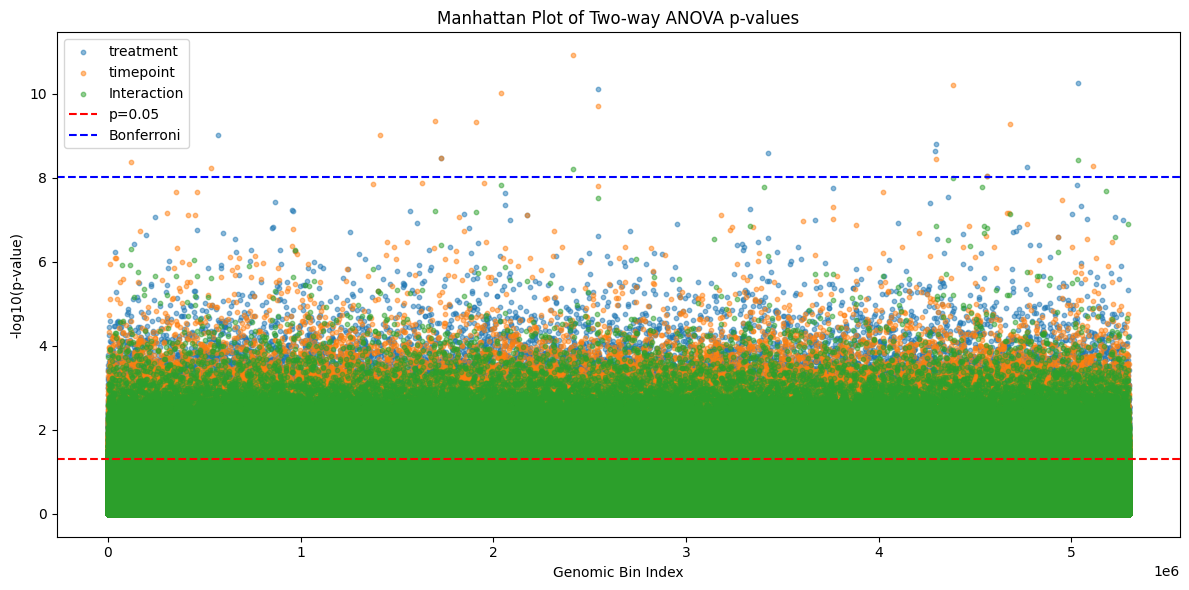

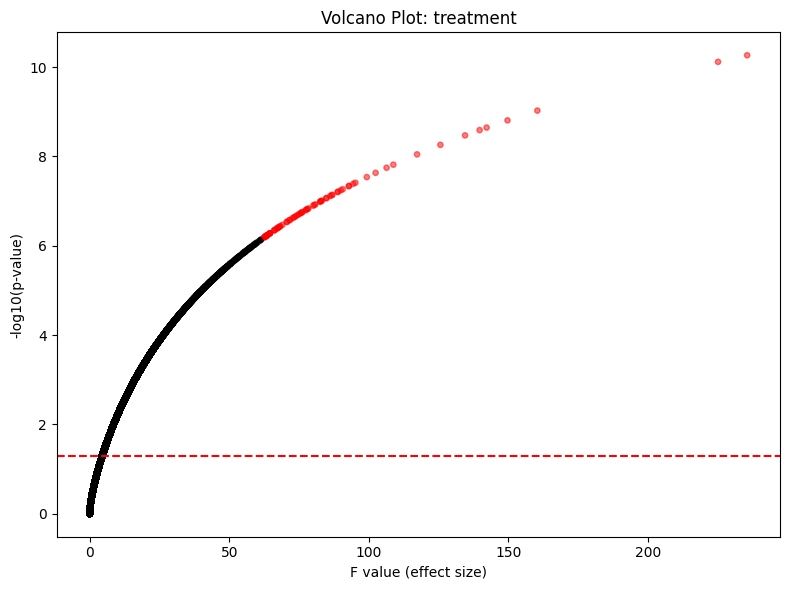

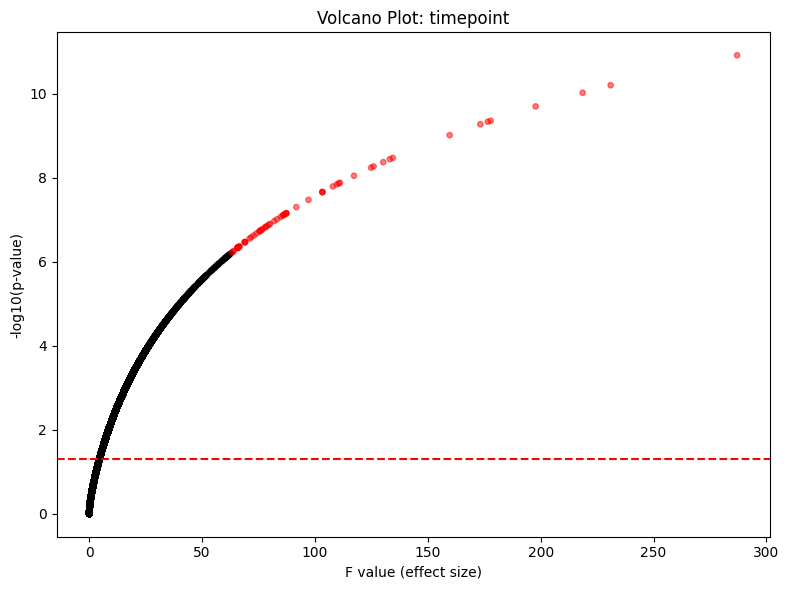

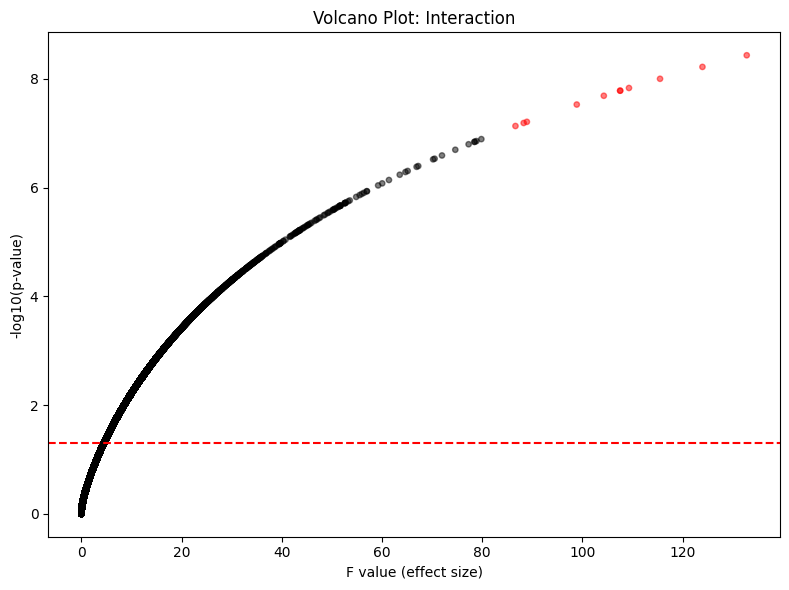

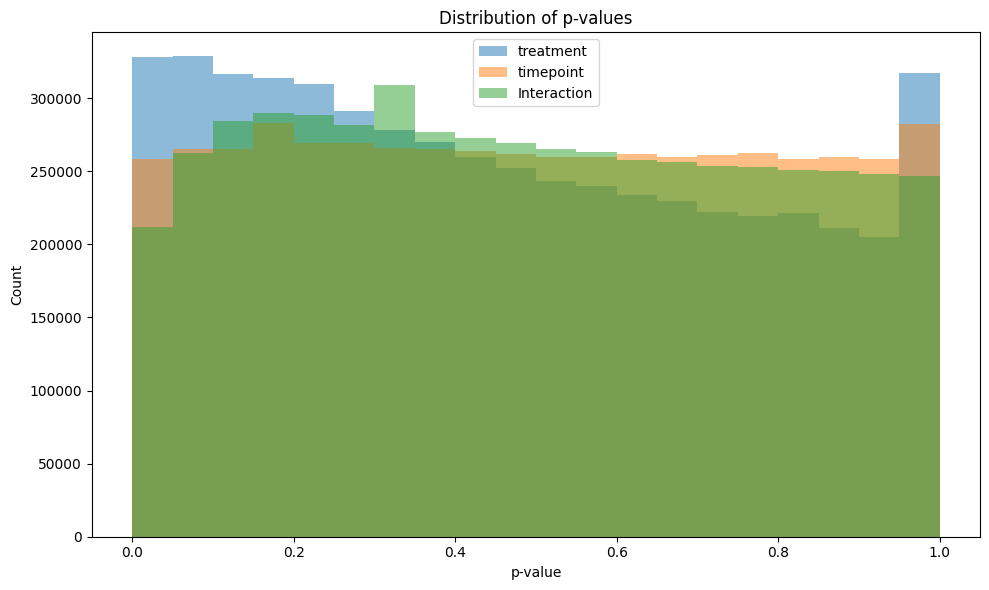

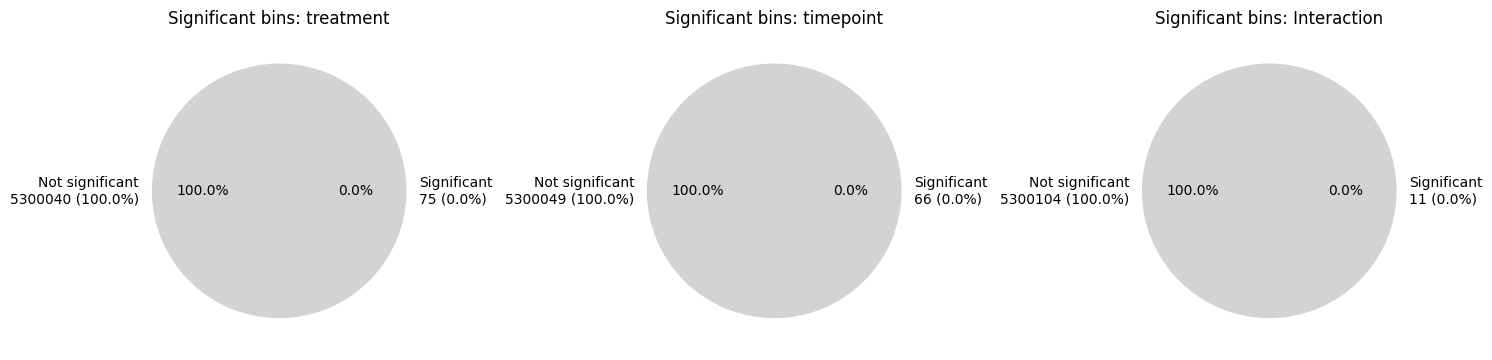

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

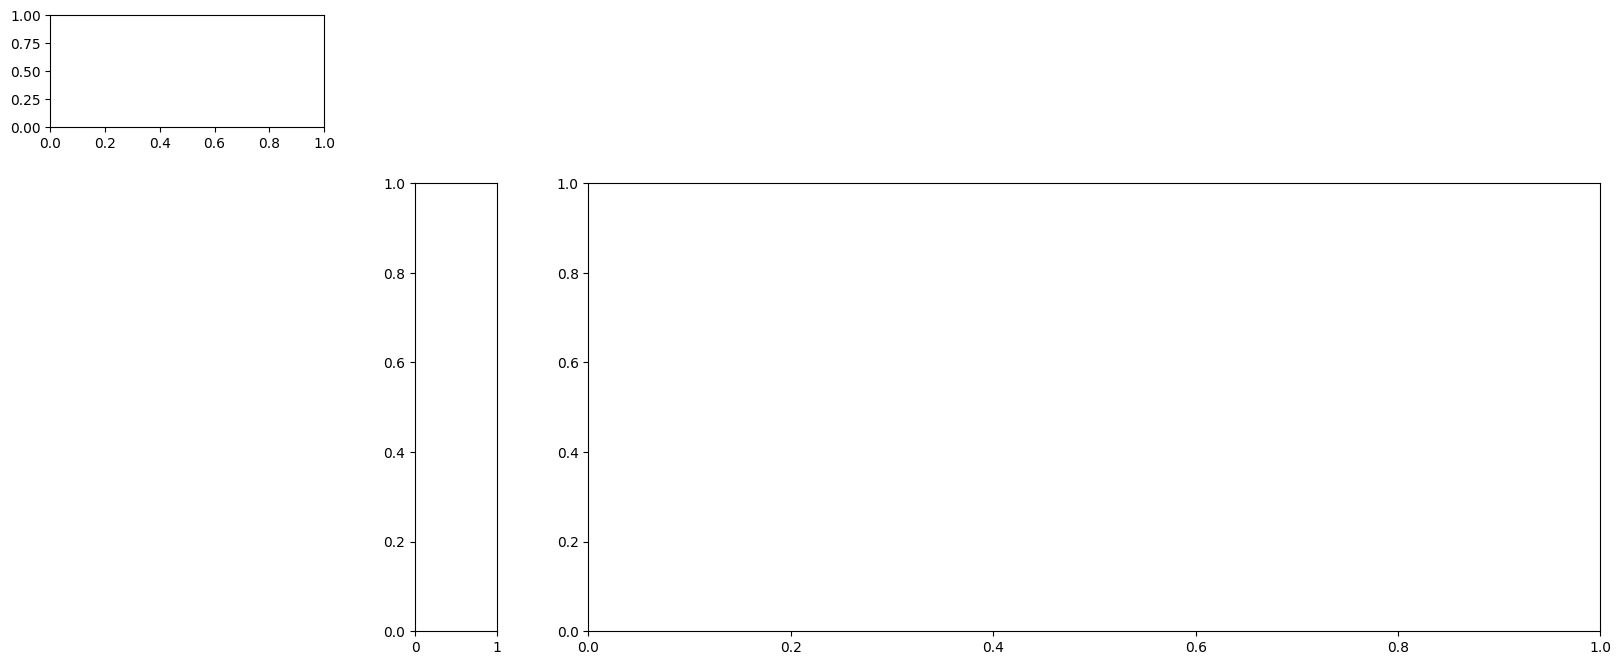

<Figure size 1000x800 with 0 Axes>

In [13]:
# 4. Run the analysis

results_df = analyze_genomic_bins(file_path, 
                                factor1_name, factor2_name, None, 
                                figures_dir, data_dir, 32, 5000)

# 5. Examine resultsq
display(results_df.head())
print(f"Significant for {factor1_name}: {results_df['factor1_significant'].sum()}")
print(f"Significant for {factor2_name}: {results_df['factor2_significant'].sum()}")
print(f"Significant for interaction: {results_df['interaction_significant'].sum()}")

# 6. Create visualizations
visualize_anova_results(results_df, factor1_name, factor2_name, None, figures_dir, data_dir)

# 7. Visualize top significant bins
plot_significant_bins(file_path, results_df, factor1_name, factor2_name, None, 10, figures_dir)

# 8. Create heatmaps
create_heatmap(file_path, results_df, factor1_name, factor2_name, 50, figures_dir)